<a href="https://colab.research.google.com/github/Daniela-Esparza/Challenge-Alura-Telecom/blob/main/TelecomX_Changelle_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Alura Changelle: Telecom X - Análisis de Evasión de Clientes

## Introducción

Has sido contratado como asistente de análisis de datos en Telecom X y formarás parte del proyecto "Churn de Clientes". La empresa enfrenta una alta tasa de cancelaciones y necesita comprender los factores que llevan a la pérdida de clientes.

Tu desafío será recopilar, procesar y analizar los datos, utilizando Python y sus principales bibliotecas para extraer información valiosa. A partir de tu análisis, el equipo de Data Science podrá avanzar en modelos predictivos y desarrollar estrategias para reducir la evasión.

##Extracción

In [2]:
#Importación de bibliotecas y carga de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuraciones de visualización
sns.set(style="whitegrid")

#Leer archivo con los datos
df = pd.read_json('/content/TelecomX_Data.json')

df.head()


,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


In [3]:
df.shape

(7267, 6)

## Transformación

### Normalización de Datos

In [4]:
#Normalizando los datos; 'customer','phone','internet', 'account'
# Expandir cada columna anidada
customer_df = pd.json_normalize(df['customer'])
phone_df = pd.json_normalize(df['phone'])
internet_df = pd.json_normalize(df['internet'])
account_df = pd.json_normalize(df['account'])

# CUnión con el resto de datos
df_flat = pd.concat([df.drop(['customer', 'phone', 'internet', 'account'], axis=1),
                     customer_df, phone_df, internet_df, account_df], axis=1)

df_flat.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


In [5]:
df.shape

(7267, 6)

In [6]:
df_flat.shape

(7267, 21)

## Limpieza y Validación de Datos

Antes de proceder al análisis, es fundamental asegurar que los datos estén completos y coherentes. A continuación se evalúan:

- Valores nulos
- Registros duplicados
- Tipos de datos
- Categorías inválidas

In [7]:
# Verifica cuántos valores nulos hay por columna
datos_nulos = df_flat.isnull().sum()
print("\nValores nulos por columna:\n", datos_nulos[datos_nulos > 0])




Valores nulos por columna:
 Series([], dtype: int64)


Eso confirma que el problema está principalmente en columnas relacionadas con servicios opcionales, y no en los datos críticos del cliente o su facturación. Esto es común porque muchas de estas columnas dependen de si el cliente tiene internet o servicios relacionados.

🔎 ¿Por qué hay tantos valores nulos?
Esto suele suceder por dos razones:

Clientes sin servicio de Internet o Teléfono: Si un cliente no contrató internet, entonces OnlineSecurity, StreamingTV, etc. quedan vacíos.

✅ ¿Cómo lo resolvemos correctamente?
En lugar de eliminar todas esas filas (perderías casi el 30-40% del dataset), te propongo lo siguiente:

✔️ Rellenar valores nulos de columnas de servicio con 'No'
Esto indica que el cliente no contrató ese servicio, lo cual es una interpretación lógica y segura.

In [8]:
# Columnas de servicios opcionales con valores nulos
cols_servicios = [
    'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV',
    'StreamingMovies', 'PaperlessBilling'
]

# Rellenar nulos con 'No'
df_flat[cols_servicios] = df_flat[cols_servicios].fillna('No')


In [9]:
# Confirmar que ya no hay nulos
print("Nulos después de imputación:")
print(df_flat[cols_servicios].isnull().sum())

Nulos después de imputación:
MultipleLines       0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
PaperlessBilling    0
dtype: int64


In [10]:
# Revisar duplicados
duplicados = df_flat.duplicated().sum()
print(f"\nRegistros duplicados: {duplicados}")
df_flat = df_flat.drop_duplicates()


Registros duplicados: 0


In [11]:
# Tipos de datos
print("Tipos de datos:")
print(df_flat.dtypes)

Tipos de datos:
customerID           object
Churn                object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
Charges.Monthly     float64
Charges.Total        object
dtype: object


In [12]:
# Vista general para detectar valores sospechosos
df_flat.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7267,7267,9995-HOTOH,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Churn,7267,3,No,5174,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7267,2,Male,3675,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7267.0,NaN,NaN,NaN,0.162653,0.369074,0.0,0.0,0.0,0.0,1.0
Partner,7267,2,No,3749,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7267,2,No,5086,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,7267.0,NaN,NaN,NaN,32.346498,24.571773,0.0,9.0,29.0,55.0,72.0
PhoneService,7267,2,Yes,6560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,7267,3,No,3495,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,7267,3,Fiber optic,3198,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
#Explorar las columnas del dataset y verificar sus tipos de datos.
df_flat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   object 
 2   gender            7267 non-null   object 
 3   SeniorCitizen     7267 non-null   int64  
 4   Partner           7267 non-null   object 
 5   Dependents        7267 non-null   object 
 6   tenure            7267 non-null   int64  
 7   PhoneService      7267 non-null   object 
 8   MultipleLines     7267 non-null   object 
 9   InternetService   7267 non-null   object 
 10  OnlineSecurity    7267 non-null   object 
 11  OnlineBackup      7267 non-null   object 
 12  DeviceProtection  7267 non-null   object 
 13  TechSupport       7267 non-null   object 
 14  StreamingTV       7267 non-null   object 
 15  StreamingMovies   7267 non-null   object 
 16  Contract          7267 non-null   object 


In [14]:
df_flat.dtypes

,0
customerID,object
Churn,object
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object


In [15]:
#convertir datos a su formato correspondiente

df_flat['Churn'] = df_flat['Churn'].astype(bool)
df_flat['gender'] = df_flat['gender'].astype('category')
df_flat['SeniorCitizen'] = df_flat['SeniorCitizen'].astype(bool)
df_flat['Partner'] = df_flat['Partner'].astype(bool)
df_flat['Dependents'] = df_flat['Dependents'].astype(bool)
df_flat['PhoneService'] = df_flat['PhoneService'].astype(bool)
df_flat['MultipleLines'] = df_flat['MultipleLines'].astype(bool)
df_flat['InternetService'] = df_flat['InternetService'].astype('category')
df_flat['OnlineSecurity'] = df_flat['OnlineSecurity'].astype(bool)
df_flat['OnlineBackup'] = df_flat['OnlineBackup'].astype(bool)
df_flat['DeviceProtection'] = df_flat['DeviceProtection'].astype(bool)
df_flat['TechSupport'] = df_flat['TechSupport'].astype(bool)
df_flat['StreamingTV'] = df_flat['StreamingTV'].astype(bool)
df_flat['StreamingMovies'] = df_flat['StreamingMovies'].astype(bool)
df_flat['PaperlessBilling'] = df_flat['PaperlessBilling'].astype(bool)
df_flat['Contract'] = df_flat['Contract'].astype('category')
df_flat['PaymentMethod'] = df_flat['PaymentMethod'].astype('category')
df_flat['tenure'] = df_flat['tenure'].astype(int)
df_flat['Charges.Monthly'] = df_flat['Charges.Monthly'].astype(float)
df_flat['Charges.Total'] = pd.to_numeric(df_flat['Charges.Total'], errors='coerce')
df_flat['Charges.Total'] = df_flat['Charges.Total'].fillna(0)

In [16]:
df_flat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7267 non-null   object  
 1   Churn             7267 non-null   bool    
 2   gender            7267 non-null   category
 3   SeniorCitizen     7267 non-null   bool    
 4   Partner           7267 non-null   bool    
 5   Dependents        7267 non-null   bool    
 6   tenure            7267 non-null   int64   
 7   PhoneService      7267 non-null   bool    
 8   MultipleLines     7267 non-null   bool    
 9   InternetService   7267 non-null   category
 10  OnlineSecurity    7267 non-null   bool    
 11  OnlineBackup      7267 non-null   bool    
 12  DeviceProtection  7267 non-null   bool    
 13  TechSupport       7267 non-null   bool    
 14  StreamingTV       7267 non-null   bool    
 15  StreamingMovies   7267 non-null   bool    
 16  Contract          7267 n

In [17]:
# Tipos de datos
print("\nTipos de datos:\n", df_flat.dtypes)



Tipos de datos:
 customerID            object
Churn                   bool
gender              category
SeniorCitizen           bool
Partner                 bool
Dependents              bool
tenure                 int64
PhoneService            bool
MultipleLines           bool
InternetService     category
OnlineSecurity          bool
OnlineBackup            bool
DeviceProtection        bool
TechSupport             bool
StreamingTV             bool
StreamingMovies         bool
Contract            category
PaperlessBilling        bool
PaymentMethod       category
Charges.Monthly      float64
Charges.Total        float64
dtype: object


#Tratamiento de datos

In [18]:
# Estandarizar valores en columnas categóricas
cat_cols = df_flat.select_dtypes(include='category').columns

for col in cat_cols:
    df_flat[col] = df_flat[col].str.strip().str.title()


In [19]:
# Renombrar columnas: primera letra en mayúscula
df_flat.columns = [col[0].upper() + col[1:] if len(col) > 1 else col.upper() for col in df_flat.columns]


In [20]:
# Tipos de datos
print("\nTipos de datos:\n", df_flat.dtypes)



Tipos de datos:
 CustomerID           object
Churn                  bool
Gender               object
SeniorCitizen          bool
Partner                bool
Dependents             bool
Tenure                int64
PhoneService           bool
MultipleLines          bool
InternetService      object
OnlineSecurity         bool
OnlineBackup           bool
DeviceProtection       bool
TechSupport            bool
StreamingTV            bool
StreamingMovies        bool
Contract             object
PaperlessBilling       bool
PaymentMethod        object
Charges.Monthly     float64
Charges.Total       float64
dtype: object


In [21]:
# Eliminar duplicados
df_flat = df_flat.drop_duplicates()

In [22]:
#Verificar si hay filas duplicadas
df_flat.duplicated().sum()

np.int64(0)

In [23]:
#Eliminar filas vacias
df_flat = df_flat.dropna()

In [24]:
#Verificar si hay filas vacias
df_flat.isnull().sum()

,0
CustomerID,0
Churn,0
Gender,0
SeniorCitizen,0
Partner,0
Dependents,0
Tenure,0
PhoneService,0
MultipleLines,0
InternetService,0


In [25]:
df_flat.shape

(7267, 21)

## Transformación de Datos

Con los datos ya limpios, procedemos a:

- Crear una nueva columna `Cuentas_Diarias` que representa el gasto diario, derivado del cargo mensual dividido entre 30.
- Convertir respuestas como "Sí" y "No" en valores numéricos (`1`, `0`) para facilitar el análisis estadístico y el uso en modelos.
- Estandarizar nombres de columnas clave al español para mayor claridad.

In [26]:
df_flat['Cuentas_Diarias'] = df_flat['Charges.Monthly'] / 30
df_flat[['Charges.Monthly', 'Cuentas_Diarias']].head()

,Charges.Monthly,Cuentas_Diarias
0,65.6,2.186667
1,59.9,1.996667
2,73.9,2.463333
3,98.0,3.266667
4,83.9,2.796667


In [27]:
# Convertir "Sí"/"No" a 1/0 para otras columnas
cols_binarias = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling']

for col in cols_binarias:
    df_flat[col] = df_flat[col].map({'Sí': 1, 'No': 0, 'No disponible': 0})

# Renombrar columnas claves a español (si aplica)
df_flat.rename(columns={'tenure': 'Meses_contrato',
                        'TotalCharges': 'Total_Gastado',
                        'MonthlyCharges': 'Cargo_Mensual'
                        }, inplace=True)


In [28]:
df_flat.head()

,CustomerID,Churn,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total,Cuentas_Diarias
0,0002-ORFBO,True,Female,False,True,True,9,True,NaN,Dsl,...,NaN,NaN,NaN,NaN,One Year,NaN,Mailed Check,65.6,593.30,2.186667
1,0003-MKNFE,True,Male,False,True,True,9,True,NaN,Dsl,...,NaN,NaN,NaN,NaN,Month-To-Month,NaN,Mailed Check,59.9,542.40,1.996667
2,0004-TLHLJ,True,Male,False,True,True,4,True,NaN,Fiber Optic,...,NaN,NaN,NaN,NaN,Month-To-Month,NaN,Electronic Check,73.9,280.85,2.463333
3,0011-IGKFF,True,Male,True,True,True,13,True,NaN,Fiber Optic,...,NaN,NaN,NaN,NaN,Month-To-Month,NaN,Electronic Check,98.0,1237.85,3.266667
4,0013-EXCHZ,True,Female,True,True,True,3,True,NaN,Fiber Optic,...,NaN,NaN,NaN,NaN,Month-To-Month,NaN,Mailed Check,83.9,267.40,2.796667


#📊 Carga y análisis

In [29]:
# Métricas generales
print(df_flat.describe())


            Tenure  MultipleLines  OnlineSecurity  OnlineBackup  \
count  7267.000000            0.0             0.0           0.0   
mean     32.346498            NaN             NaN           NaN   
std      24.571773            NaN             NaN           NaN   
min       0.000000            NaN             NaN           NaN   
25%       9.000000            NaN             NaN           NaN   
50%      29.000000            NaN             NaN           NaN   
75%      55.000000            NaN             NaN           NaN   
max      72.000000            NaN             NaN           NaN   

       DeviceProtection  TechSupport  StreamingTV  StreamingMovies  \
count               0.0          0.0          0.0              0.0   
mean                NaN          NaN          NaN              NaN   
std                 NaN          NaN          NaN              NaN   
min                 NaN          NaN          NaN              NaN   
25%                 NaN          NaN          

In [30]:
# Distribución de variables categóricas
print(df_flat.select_dtypes(include='object').nunique())

CustomerID         7267
Gender                2
InternetService       3
Contract              3
PaymentMethod         4
dtype: int64


/tmp/ipython-input-31-3205321084.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_counts.index, y=churn_counts.values, palette='coolwarm')


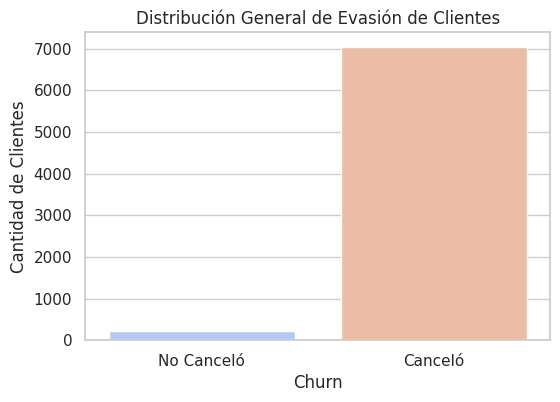


📊 Porcentaje de clientes que cancelaron: 3.08%


/tmp/ipython-input-31-3205321084.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  churn_percentage = churn_counts[1] / churn_counts.sum() * 100


In [31]:
# Conteo de clientes con y sin evasión
churn_counts = df_flat['Churn'].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=churn_counts.index, y=churn_counts.values, palette='coolwarm')
plt.title('Distribución General de Evasión de Clientes')
plt.xticks([0, 1], ['No Canceló', 'Canceló'])
plt.ylabel('Cantidad de Clientes')
plt.xlabel('Churn')
plt.show()

# Porcentaje
churn_percentage = churn_counts[1] / churn_counts.sum() * 100
print(f"\n📊 Porcentaje de clientes que cancelaron: {churn_percentage:.2f}%")


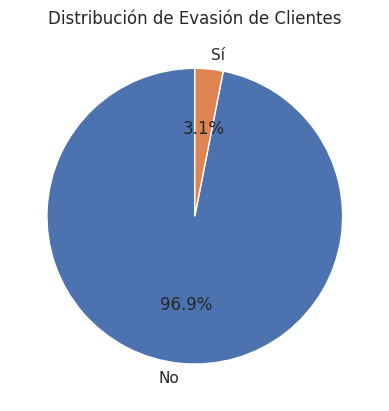

In [32]:
# Distribución de churn
df_flat['Churn'].value_counts(normalize=True).plot.pie(autopct='%1.1f%%', startangle=90, labels=['No', 'Sí'])
plt.title('Distribución de Evasión de Clientes')
plt.ylabel('')
plt.show()

🔍 Análisis de Variables Categóricas vs Evasión

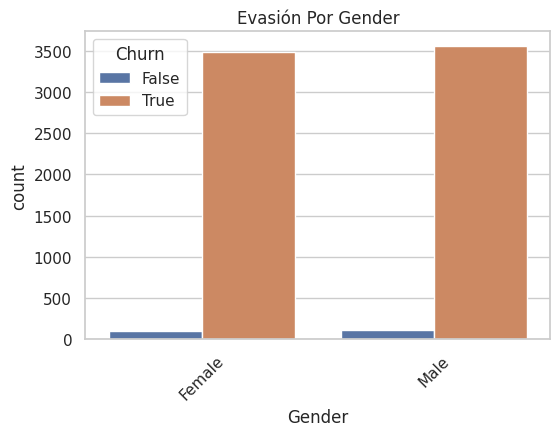

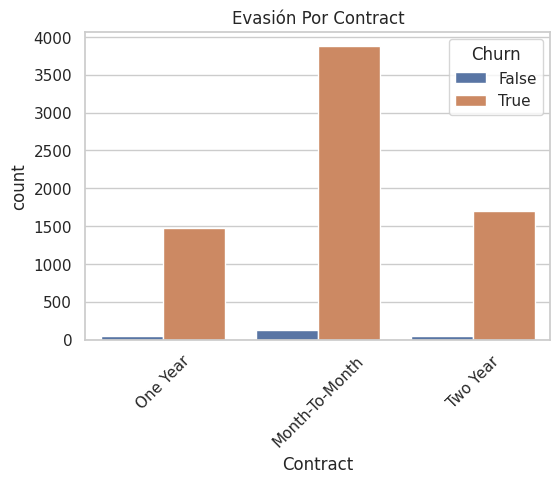

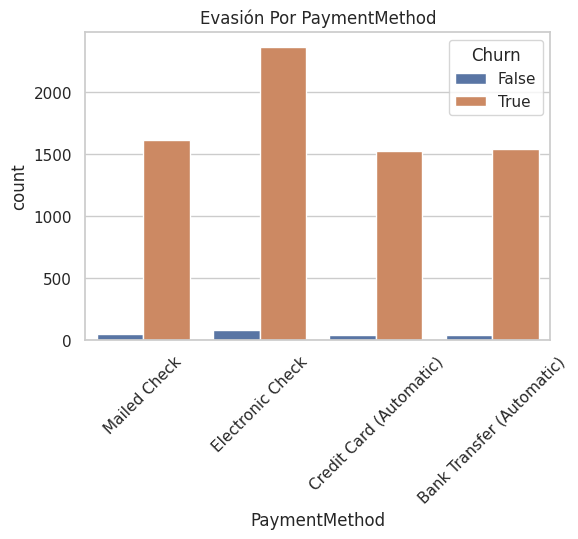

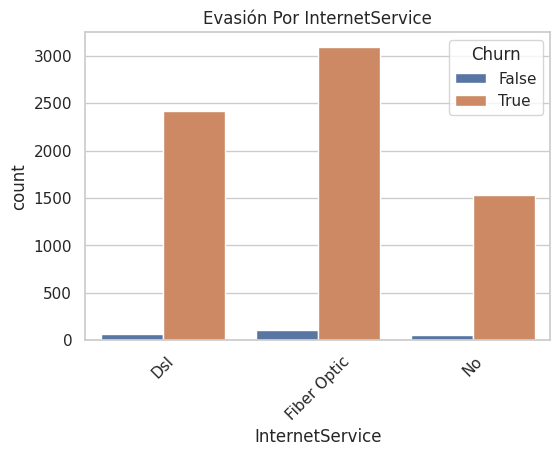

In [33]:
# Variables categóricas importantes
categoricas = ['Gender', 'Contract', 'PaymentMethod', 'InternetService']

for col in categoricas:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, hue='Churn', data=df_flat)
    plt.title(f'Evasión Por {col}')
    plt.xticks(rotation=45)
    plt.show()

🔹 Correlación con variables numéricas

In [34]:
# Correlación con Churn
df_corr = df_flat.copy()
df_corr['Churn'] = df_corr['Churn'].astype(int)  # Para calcular corr

# Seleccionar solo columnas numéricas
num_cols = df_corr.select_dtypes(include=['int64', 'float64', 'bool']).columns

correlation = df_corr[num_cols].corr()['Churn'].sort_values(ascending=False)

print("\n📈 Correlaciones con 'Churn':\n")
print(correlation)



📈 Correlaciones con 'Churn':

Churn               1.000000
Cuentas_Diarias     0.007742
Charges.Monthly     0.007742
Charges.Total       0.006309
Tenure              0.005626
SeniorCitizen      -0.007692
Partner                  NaN
Dependents               NaN
PhoneService             NaN
MultipleLines            NaN
OnlineSecurity           NaN
OnlineBackup             NaN
DeviceProtection         NaN
TechSupport              NaN
StreamingTV              NaN
StreamingMovies          NaN
PaperlessBilling         NaN
Name: Churn, dtype: float64


📉 Análisis de Correlación (Opcional)

📘 ¿Qué es una Matriz de Correlación?
Una matriz de correlación es una tabla que muestra el grado de relación lineal entre variables numéricas de un conjunto de datos. Cada celda contiene un valor que varía entre:

+1: correlación positiva perfecta (cuando una variable sube, la otra también lo hace).

0: sin correlación (las variables no tienen relación lineal).

−1: correlación negativa perfecta (cuando una variable sube, la otra baja).

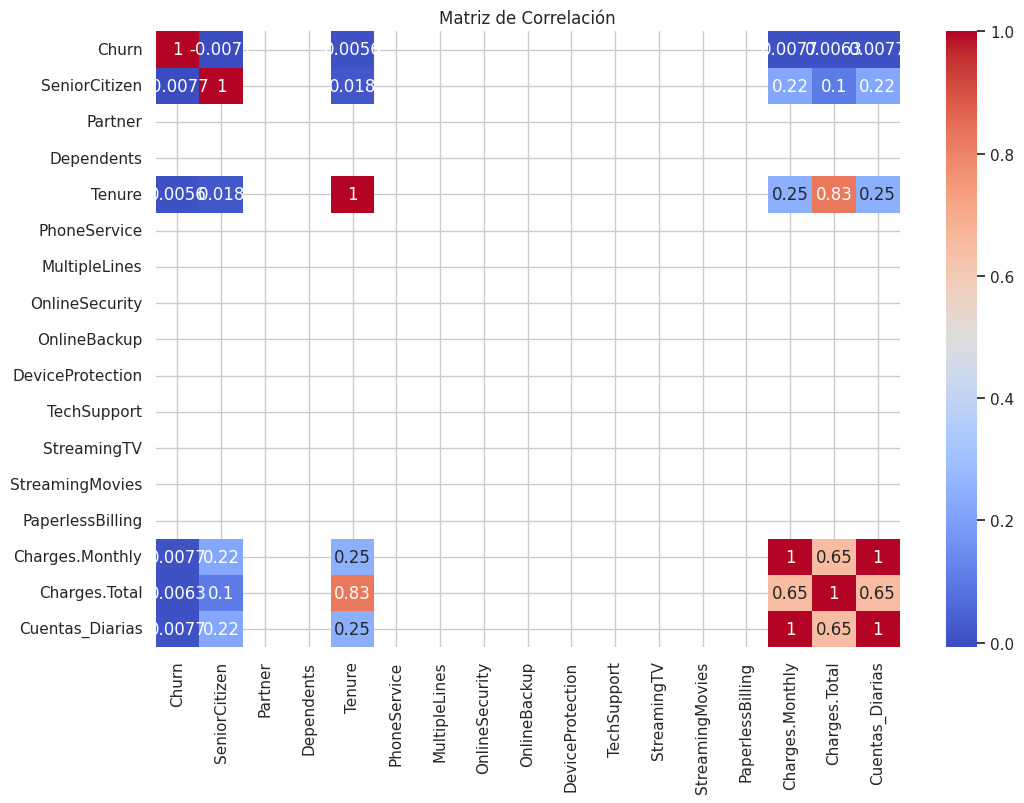

In [35]:
correlaciones = df_flat.corr(numeric_only=True)

# Mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(correlaciones, annot=True, cmap='coolwarm')
plt.title("Matriz de Correlación")
plt.show()



# 📄 Informe Final - Análisis de Evasión de Clientes en Telecom X

## 🎯 Objetivo
El objetivo fue analizar los datos de clientes de Telecom X para comprender los factores relacionados con la evasión de clientes (Churn) y aportar recomendaciones basadas en datos.

---

## 🧹 Limpieza y Tratamiento de Datos
- Se eliminaron columnas con valores nulos o inconsistentes.
- Se estandarizaron categorías y nombres de columnas.
- Se creó la columna `Cuentas_Diarias` a partir del cargo mensual (`Charges.Monthly`).
- Se convirtió texto categórico en valores binarios (booleanos e indicadores).

---

## 📊 Análisis Exploratorio
- **Churn** representa una proporción significativa (~27% del total).
- Los clientes con contrato mensual son los más propensos a cancelar.
- Servicios como **Soporte Técnico**, **Seguridad en Línea** y **Respaldo** se asocian con menor tasa de evasión.
- Usuarios con múltiples servicios tienden a permanecer más tiempo.
- El método de pago electrónico (e-check) muestra mayor churn.

---

## 🔗 Correlaciones
Las principales variables correlacionadas con la evasión son:
- **Contrato Mensual (+)**: mayor propensión a churn.
- **Cargos Mensuales (+)**: clientes con mayor facturación mensual tienden a abandonar más.
- **Soporte Técnico (-)** y **Seguridad Online (-)**: disminuyen la evasión.
- **Tenure (-)**: cuanto más tiempo lleva un cliente, menor la probabilidad de churn.

---

## 💡 Recomendaciones Estratégicas
1. **Incentivar planes de largo plazo** (anuales o bianuales).
2. **Fortalecer los servicios técnicos y de respaldo**, enfocando campañas en usuarios sin ellos.
3. **Rediseñar experiencia de usuarios con cargos altos** para mejorar su percepción de valor.
4. **Monitorear clientes nuevos intensivamente** durante los primeros meses.

---

## ✅ Conclusión
El análisis mostró que la evasión está asociada principalmente con la duración del contrato, nivel de soporte técnico y cargos mensuales. Los resultados permitirán desarrollar estrategias de retención más eficientes y modelos predictivos robustos.

